<a href="https://colab.research.google.com/github/EkuDS1/twitter-user-locator/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
# Make sure gensim version is 4.x.x
!pip install gensim --upgrade

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import csv

# For getting trained word embeddings
from gensim.models import FastText

# getting rid of Tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# used for deep learning
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l1
import tensorflow.keras.backend as K

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing
### Load Data
Defines function that load the data and returns it as tensors of latitude, longitude and all tweets for a twitter user. Also defines function that optimizes datasets.

In [ ]:
# Code for optimizing dataset performance
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Load file and return datasets for text and location and their combined training dataset
def loadData(data_path):
    df = pd.read_csv(data_path, delimiter='\t', encoding='utf-8', names=['user', 'lat', 'lon', 'text'],
                     quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    
    # Normalize coordinates so that mean is 0 and std is 1
    # df[['lat', 'lon']] = (df[['lat', 'lon']]-df[['lat', 'lon']].mean())/df[['lat', 'lon']].std()

    # Get latitude, longitude and tweets separately
    lat = df['lat']
    lon = df ['lon']
    text = df ['text']
    
    # Remove ||| separator and replace with space
    text = text.str.lstrip(" |")
    text = text.str.replace(" \|\|\| ", " ", regex=True)
    
    # Convert all to tensor and return
    lat = tf.convert_to_tensor(lat)
    lon = tf.convert_to_tensor(lon)
    text = tf.convert_to_tensor(text)
    
    # Convert to text dataset and location dataset respectively
    text_ds = tf.data.Dataset.from_tensor_slices(text)
    location_ds = tf.data.Dataset.from_tensor_slices((lat, lon))
    trainingData = tf.data.Dataset.zip((text_ds, location_ds))

    # Configure datasets for performance
    text_ds = configure_dataset(text_ds)
    location_ds = configure_dataset(location_ds)
    trainingData = configure_dataset(trainingData)
    
    # Return datasets
    return text_ds, location_ds, trainingData

Tensors are then turned into datasets that can be split into batches.

In [ ]:
current_dir = Path('/content/drive/My Drive/')
data_path = current_dir / 'geoworld/user_info.dev'
output_path = current_dir / 'dev_output'
embeddings_path = output_path / 'embeddings-dev.model'

# Get datasets from data file
text_ds, location_ds, trainingData = loadData(data_path)

### Text Vectorization
Now we have to convert each string of text in the data into an array of integers where every integer is an index that belongs to a word. This is done so that we can input data into our model.

In [ ]:
# Turns each string of text into an array of integers
MAX_SEQUENCE_LENGTH = 250

# Create TextVectorization layer and build vocabulary from dataset
# This layer takes an input array of strings of shape (batch_size) and outputs arrays of shape (batch_size, MAX_SEQUENCE_LENGTH)
vectorize_layer = tfl.TextVectorization(output_sequence_length=MAX_SEQUENCE_LENGTH)
vectorize_layer.adapt(text_ds.batch(128))

# Save vocabulary and vocabulary size
vocab = vectorize_layer.get_vocabulary()
VOCAB_SIZE = len(vocab)

### Word Embeddings
Next, we convert each integer in our data into a unique word embedding.  
The following function gets embeddings for all the words in our dataset's vocabulary and returns it as a matrix.

In [ ]:
# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models.callbacks import CallbackAny2Vec
# import time

# class callback(CallbackAny2Vec):
#     '''Callback to print loss after each epoch.'''

#     def __init__(self):
#         self.epoch = 0
#         self.starttime = 0

#     def on_epoch_begin(self, model):
#         self.starttime = time.time()
#         print("Epoch #{} start".format(self.epoch))

#     def on_epoch_end(self, model):
#         print("Epoch #{} ended in time: {} minutes".format(self.epoch, (time.time()-self.starttime)/60.0))
#         self.epoch += 1

In [ ]:
# Gets embeddings for words in the dataset. This assumes that TextVectorization has already built a vocabulary.
def get_embeddings(embed_path):
    # Create lexicons of the words 1->and
    word_index = dict(zip(vocab, range(VOCAB_SIZE)))
    
    ft_model = FastText.load(str(embed_path))
    trained_embeddings = ft_model.wv
    
    embedding_dim = 100
    hits = 0
    misses = 0
    
    # Prepare embedding matrix by matching every word in embeddings with vectorizer
    embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = trained_embeddings.get_vector(word, norm=True)
        
        if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        
            embedding_matrix[i] = embedding_vector
            hits = hits + 1
        else:
            misses = misses + 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

In [ ]:
# Turns array of integers into an array of embeddings
# Embedding Layer takes input array of shape (batch_size, MAX_SEQUENCE_LENGTH) and outputs array of shape (batch_size, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
EMBEDDING_DIM = 100

# embedding_matrix = get_embeddings(embeddings_path)
# np.save(output_path / 'embedding_matrix', embedding_matrix)

# the above commented-out code gave output: Converted 6800984 words (0 misses)
# it takes more than 10 minutes so we will save time by 
# loading an already processed matrix
embedding_matrix = np.load(output_path / 'embedding_matrix.npy')

# Create Model

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def build_model():

  input_layer = tfl.Input(shape=(1,), name="input", dtype=tf.string)

  x = vectorize_layer(input_layer)
  print(x)
  # Embedding layer
  embedding_layer = tfl.Embedding(input_dim = VOCAB_SIZE, 
                                output_dim = EMBEDDING_DIM, 
                                input_length=MAX_SEQUENCE_LENGTH,
                                embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False)(x)
  
  lstm_layer1 = tfl.LSTM(1024, name="lstm1", use_bias=True, kernel_regularizer=l1(1e-6), bias_regularizer=l1(1e-6))(embedding_layer)
  lstm_layer2 = tfl.LSTM(1024, name="lstm2", use_bias=True, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7))(embedding_layer)
  
  dense_layer1a = tfl.Dense(256, name="middle1a", activation='leaky_relu')(lstm_layer1)
  dense_layer2a = tfl.Dense(256, name="middle2a", activation='leaky_relu')(lstm_layer2)

  dense_layer1b = tfl.Dense(64, name="middle1b", activation='leaky_relu')(dense_layer1a)
  dense_layer2b = tfl.Dense(64, name="middle2b", activation='leaky_relu')(dense_layer2a)
  
  lat_pred = tfl.Dense(1, name="latitude")(dense_layer1b)
  lon_pred = tfl.Dense(1, name="longitude")(dense_layer2b)

  model = tf.keras.Model(inputs=input_layer, outputs=[lat_pred,lon_pred])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01, decay_steps=1000, decay_rate=0.96, staircase=True
  )
  optimizer = tf.keras.optimizers.Adam()

  quantile = 0.5
  model.compile(loss=lambda y,f: tilted_loss(quantile,y,f),
               optimizer=optimizer, metrics=['accuracy'])
  # model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

  return model

KerasTensor(type_spec=TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), name='text_vectorization_1/RaggedToTensor/RaggedTensorToTensor:0', description="created by layer 'text_vectorization_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 250)         0           ['input[0][0]']                  
 orization)                                                                                       
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)     38318500    ['text_vectorization_1[

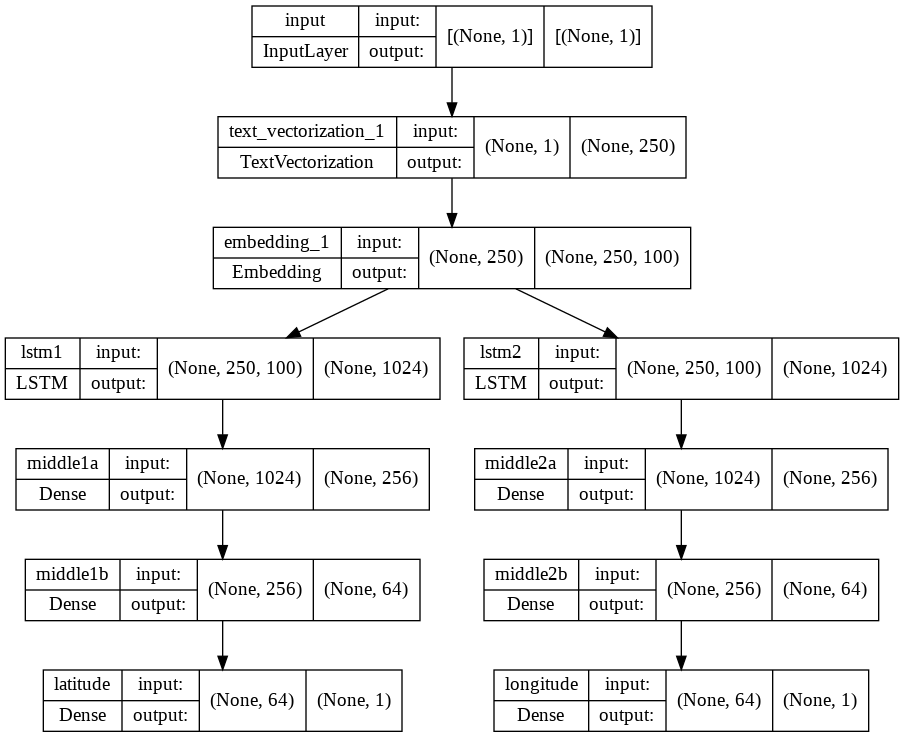

In [ ]:
# Make model
model = build_model()
model.summary()
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

# Train Model

In [ ]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cp.ckpt',
#                                                  save_weights_only=False,
#                                                  verbose=1)

history = model.fit(trainingData.batch(20), epochs=2)

# model.load_weights(current_dir / 'trained_model/checkpoint')

Epoch 1/2
500/500 [==============================] - 82s 148ms/step - loss: 29.5336 - latitude_loss: 5.8694 - longitude_loss: 23.6595 - latitude_accuracy: 0.0000e+00 - longitude_accuracy: 0.0000e+00
Epoch 2/2
500/500 [==============================] - 74s 147ms/step - loss: 29.1667 - latitude_loss: 5.7256 - longitude_loss: 23.4390 - latitude_accuracy: 0.0000e+00 - longitude_accuracy: 0.0000e+00


## Evaluate on Dev set

In [ ]:
# get dev set
data_path = current_dir / Path('geoworld/user_info.dev')

# Get datasets from dev file
text_ds_test, location_ds_test, testData = loadData(data_path)

model.evaluate(testData.batch(100))

100/100 [==============================] - 14s 133ms/step - loss: 28.9019 - latitude_loss: 5.6549 - longitude_loss: 23.2452 - latitude_accuracy: 0.0000e+00 - longitude_accuracy: 0.0000e+00


[28.901859283447266, 5.654868125915527, 23.245210647583008, 0.0, 0.0]

## Evaluate on Test set

In [ ]:
# get test set
data_path = current_dir / Path('geoworld/user_info.test')

# Get datasets from test file
text_ds_test, location_ds_test, testData = loadData(data_path)
  
model.evaluate(testData.batch(100))

100/100 [==============================] - 13s 129ms/step - loss: 29.0017 - latitude_loss: 5.8349 - longitude_loss: 23.1650 - latitude_accuracy: 0.0000e+00 - longitude_accuracy: 0.0000e+00


[29.00166893005371, 5.834916591644287, 23.164974212646484, 0.0, 0.0]

## Check Predictions

Check predictions for the first 20 samples in the training set.

In [ ]:
for item in trainingData.batch(1).take(20):
  print(item[1][0].numpy(), item[1][1].numpy())

[29.76328] [-95.36327]
[32.29876] [-90.18481]
[39.17316] [-77.27165]
[51.51279] [-0.09184]
[38.58157] [-121.4944]
[-2.91673] [104.7458]
[-0.8917] [119.8707]
[39.04372] [-77.48749]
[39.29038] [-76.61219]
[44.97997] [-93.26384]
[30.26715] [-97.74306]
[30.69436] [-88.04305]
[44.97997] [-93.26384]
[39.70471] [-105.08137]
[47.65966] [-117.42908]
[-1.45583] [-48.50444]
[-3.32442] [114.591]
[30.69436] [-88.04305]
[34.00071] [-81.03481]
[55.86515] [-4.25763]


In [ ]:
pred = model.predict(trainingData.batch(1).take(20))

In [ ]:
for i in range(len(pred[0])):
  print(pred[0][i], pred[1][i])

[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.385128] [-79.020515]
[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.385082] [-79.01992]
[40.384758] [-79.019264]
[40.38475] [-79.02034]
[40.385098] [-79.02023]
[40.38531] [-79.01961]
[40.384983] [-79.01904]
[40.384758] [-79.019264]
[40.384758] [-79.019264]
[40.385178] [-79.01952]
[40.385338] [-79.019615]
[40.384758] [-79.019264]
[40.385326] [-79.01919]


## How many within 100 miles?

Calculate what percentage of predictions are within 100 miles of their actual location.

In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
  R = 6372.795
  dlat = math.radians(lat2-lat1)
  dlon = math.radians(lon2-lon1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  return R * c

pred = model.predict(testData.batch(100))